In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [51]:
df=pd.read_csv(r"C:\Users\Lenovo\PycharmProjects\pythonProject\PTB_XL\ECG_Feature_Extraction\k20_extracted_features.csv")


In [53]:
#Lets check out the dataset first
print('data base 5 first rows \n')
display(df.head())
print('\n')
print('data base information \n')
display(df.info())
print('\n')
print('data base nan values')
display(df.isna().sum())
print('\n database unique values for each column\n')
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
intcolumns=df.select_dtypes(include=['float64','int64']).columns.tolist()
for i in categorical_columns:
    print(f'{i}')
    display(df[i].nunique())
    display(df[i].unique())

data base 5 first rows 



AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [55]:
df = pd.get_dummies(df, columns=categorical_columns)
df=df.astype(float)
df.head()

ValueError: 2

In [5]:
df['weight']=df['weight'].fillna(df['weight'].median())
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19860 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   HR                                  19860 non-null  float64
 1   RR                                  19860 non-null  float64
 2   R_wave_duration                     19860 non-null  float64
 3   P_wave_duration                     19860 non-null  float64
 4   T_wave_duration                     19860 non-null  float64
 5   PR_interval                         19860 non-null  float64
 6   ST_interval                         19860 non-null  float64
 7   R_peak                              19860 non-null  float64
 8   P_peak                              19860 non-null  float64
 9   Q_peak                              19860 non-null  float64
 10  S_peak                              19860 non-null  float64
 11  diagnostic_superclass               19860 non-

In [133]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

ValueError: could not convert string to float: 'Left Axis Deviation'

<Figure size 1500x1500 with 0 Axes>

<Axes: xlabel='diagnostic_superclass', ylabel='Count'>

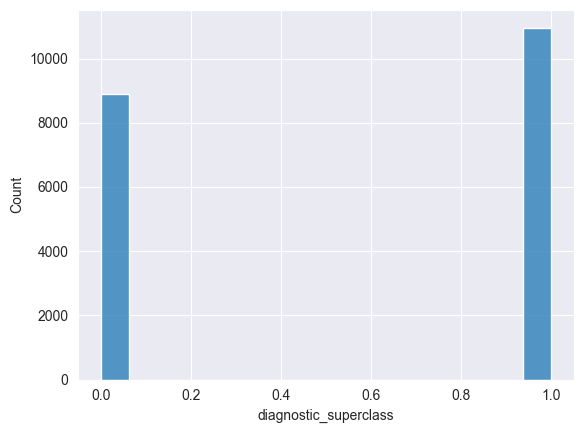

In [7]:
sns.histplot(df['diagnostic_superclass'])

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [9]:
def plot_precison_recall(model,trainx,trainy,cv,method):
    y_scores = cross_val_predict(model, trainx, trainy, cv=cv,method=method)
    if method=='predict_proba':
                y_scores=y_scores[:,1]

    precisions, recalls, thresholds = precision_recall_curve(trainy, y_scores)

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend()
    plt.show()

In [10]:
def plot_prec_over_rec(model,trainx,trainy,cv,method):
    y_scores = cross_val_predict(model, trainx, trainy, cv=cv,method=method)
    if method=='predict_proba':
            y_scores=y_scores[:,1]
    precisions, recalls, thresholds = precision_recall_curve(trainy, y_scores)
    plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")


In [11]:
from sklearn.metrics import roc_curve
def plot_roc_curve(model,trainx,trainy,cv,method):
    y_scores = cross_val_predict(model, trainx, trainy, cv=cv,method=method)
    if method=='predict_proba':
        y_scores=y_scores[:,1]
    fpr, tpr, thresholds = roc_curve(trainy, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label="ROC curve")


In [12]:
from imblearn.over_sampling import SMOTE

X=df.drop(columns=['diagnostic_superclass','patient_id'])
y=df['diagnostic_superclass']
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=0)

svc=SVC(kernel='poly',degree=3,gamma=0.4,random_state=0)
scaler=MinMaxScaler()
scaled_train_X=scaler.fit_transform(train_X)
scaled_test_X=scaler.transform(test_X)
smote=SMOTE(k_neighbors=50,random_state=42)

oversampled_x_train,oversampled_y_train=smote.fit_resample(scaled_train_X,train_y)

cross=cross_val_score(svc,oversampled_x_train,oversampled_y_train,cv=5,scoring='roc_auc')
print(cross.mean())

0.7856946672011362


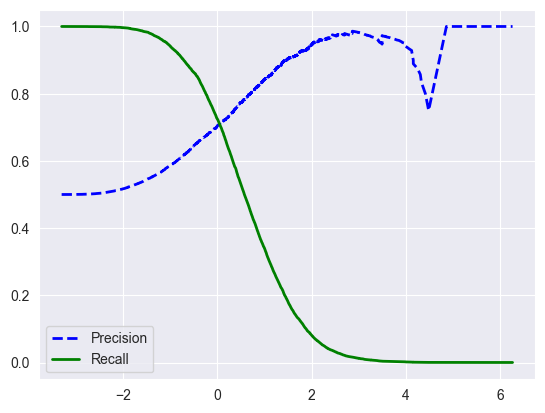

In [13]:
plot_precison_recall(svc,oversampled_x_train,oversampled_y_train,4,'decision_function')


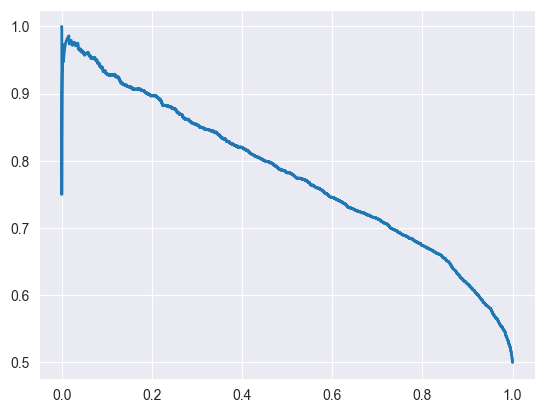

In [14]:
plot_prec_over_rec(svc,oversampled_x_train,oversampled_y_train,4,'decision_function')


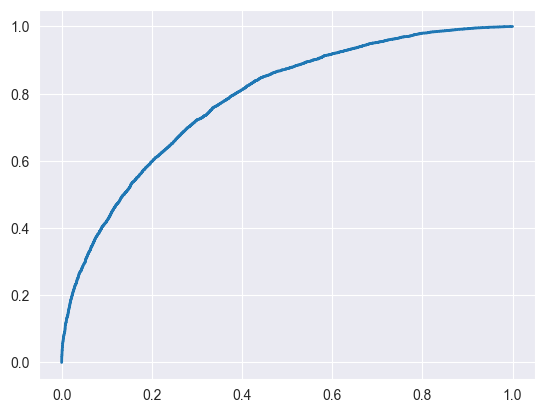

In [15]:
plot_roc_curve(svc,oversampled_x_train,oversampled_y_train,5,'decision_function')


In [16]:
from sklearn.ensemble import RandomForestClassifier

RFC=RandomForestClassifier(n_estimators=1000,max_depth=20,max_features='sqrt',min_samples_leaf=2,min_samples_split=10,bootstrap=True,random_state=0)
cross=cross_val_score(RFC,oversampled_x_train,oversampled_y_train,cv=3,scoring='roc_auc')
print(cross.mean())


0.8170947890669384


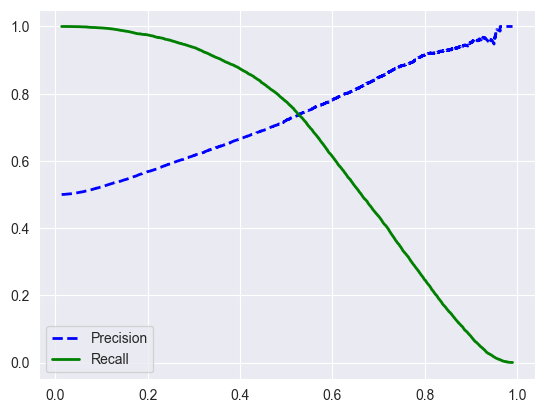

In [17]:
y_scores = cross_val_predict(RFC, oversampled_x_train, oversampled_y_train, cv=3,method="predict_proba")
y_scores_forest = y_scores[:, 1]

plot_precison_recall(RFC,oversampled_x_train,oversampled_y_train,3,'predict_proba')

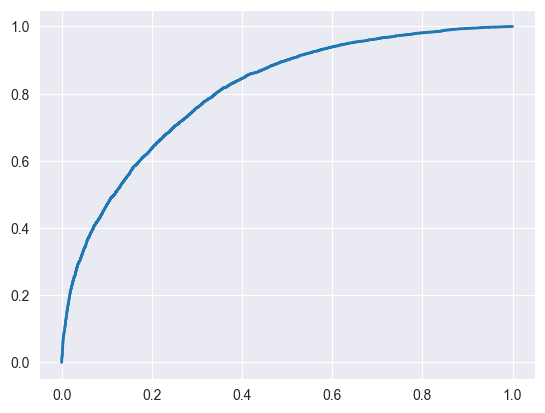

In [18]:
plot_roc_curve(RFC,oversampled_x_train,oversampled_y_train,2,'predict_proba')


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
log=GradientBoostingClassifier(n_estimators=100,learning_rate=0.01,max_depth=5,random_state=0)
cross=cross_val_score(log,oversampled_x_train,oversampled_y_train,cv=3,scoring='roc_auc')
print(cross.mean())

0.7985607174484314


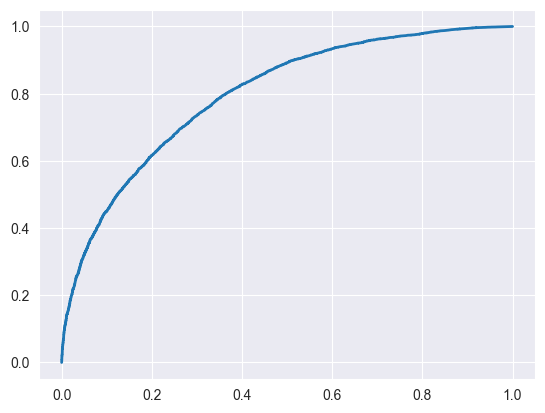

In [20]:
plot_roc_curve(log,oversampled_x_train,oversampled_y_train,3,'predict_proba')


In [21]:
from xgboost import XGBClassifier


xgb = XGBClassifier(
    n_estimators=1000,         # Number of boosting rounds
    learning_rate=0.01,        # Step size shrinkage used in update to prevent overfitting
    max_depth=5,               # Maximum depth of a tree
    gamma=5,                   # Minimum loss reduction required to make a further partition on a leaf node
    colsample_bytree=0.5,
    min_child_weight=1,        # Minimum sum of instance weight (hessian) needed in a child
    reg_alpha=0,               # L1 regularization term on weights
    reg_lambda=1,              # L2 regularization term on weights
    scale_pos_weight=1,        # Control the balance of positive and negative weights
    objective='binary:logistic',  # Specify the learning task and the corresponding learning objective
    eval_metric='auc'         # Evaluation metric for validation data
)
# Perform cross-validation
cross = cross_val_score(xgb, oversampled_x_train, oversampled_y_train, cv=3, scoring='roc_auc')

# Print the mean cross-validation score
print(cross.mean())


0.8118940096395737


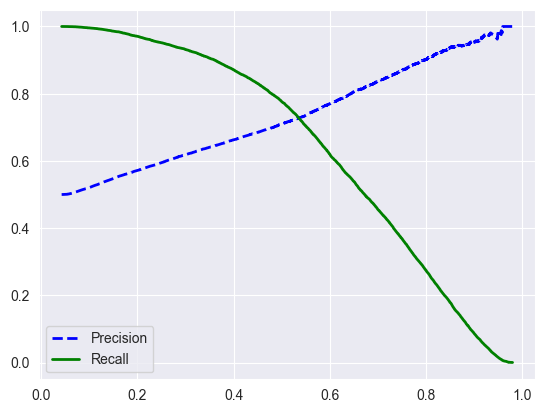

In [22]:
plot_precison_recall(xgb,oversampled_x_train,oversampled_y_train,3,'predict_proba')


In [23]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
#
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [300, 500, 1000],
#     'max_depth': [2, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }
#
# # Create a Random Forest classifier
# rf = RandomForestClassifier()
#
# # Instantiate the GridSearchCV object
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
#
# # Perform grid search
# grid_search.fit(scaled_train_X, train_y)
#
# # Print the best parameters
# print("Best parameters found: ", grid_search.best_params_)
#
# # Get the best model
# best_rf = grid_search.best_estimator_


In [24]:
# from xgboost import XGBClassifier
#
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5],
#     'min_child_weight': [1, 3, 5],
#     'scale_pos_weight': [1, 2, 3],
# }
# xgb=XGBClassifier()
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy')
# grid_search.fit(scaled_train_X, train_y)
# print("Best parameters:", grid_search.best_params_)
# print("Best accuracy:", grid_search.best_score_)
# best_XGB = grid_search.best_estimator_
#


In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50, metric='euclidean')
cross = cross_val_score(knn, oversampled_x_train, oversampled_y_train, cv=3, scoring='roc_auc')
print(cross.mean())


0.7824799266449576


In [26]:
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten
from keras.optimizers import Adam, SGD
model = Sequential([
    Dense(100, activation='relu', input_shape=(oversampled_x_train.shape[1],)),
    Dropout(0.4),
    Dense(50, activation='relu'),
    Dropout(0.4),
    Dense(25, activation='tanh'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Step 3: Compile the Model
model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Step 4: Train the Model
history = model.fit(oversampled_x_train, oversampled_y_train, epochs=500, batch_size=12, validation_split=0.1)

# Step 5: Evaluate the Model
loss, auc = model.evaluate(scaled_test_X, test_y)
print(f'Test Loss: {loss:.4f}')
print(f'Test AUC: {auc:.4f}')



Epoch 1/500


1321/1321 [==============================] - 3s 2ms/step - loss: 0.6912 - auc: 0.4936 - val_loss: 0.7963 - val_auc: 0.6168
Epoch 2/500
1321/1321 [==============================] - 2s 1ms/step - loss: 0.6871 - auc: 0.5209 - val_loss: 0.8041 - val_auc: 0.6611
Epoch 3/500
1321/1321 [==============================] - 2s 1ms/step - loss: 0.6861 - auc: 0.5293 - val_loss: 0.8030 - val_auc: 0.6678
Epoch 4/500
1321/1321 [==============================] - 2s 1ms/step - loss: 0.6836 - auc: 0.5504 - val_loss: 0.8008 - val_auc: 0.6603
Epoch 5/500
1321/1321 [==============================] - 2s 2ms/step - loss: 0.6824 - auc: 0.5601 - val_loss: 0.8016 - val_auc: 0.6682
Epoch 6/500
1321/1321 [==============================] - 2s 1ms/step - loss: 0.6793 - auc: 0.5809 - val_loss: 0.8003 - val_auc: 0.6512
Epoch 7/500
1321/1321 [==============================] - 2s 1ms/step - loss: 0.6794 - auc: 0.5775 - val_loss: 0.7907 - val_auc: 0.6558
Epoch 8/500
1321/1321 [============================

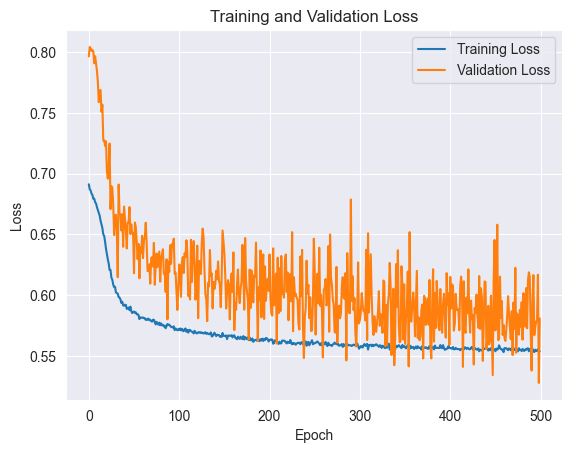

In [27]:

# Get training and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [29]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
train_losses = []
train_aucs = []
val_losses = []
val_aucs = []
training_loss=[]
validation_loss=[]
model = Sequential([
    Dense(100, activation='relu', input_shape=(oversampled_x_train.shape[1],)),
    Dropout(0.4),
    Dense(50, activation='relu'),
    Dropout(0.4),
    Dense(25, activation='tanh'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])
scaled_train_X_df = pd.DataFrame(oversampled_x_train)
train_y_df = pd.DataFrame(oversampled_y_train)
# Iterate over each fold
for train_index, val_index in skf.split(scaled_train_X, train_y):
    X_train_fold, X_val_fold = scaled_train_X_df.iloc[train_index], scaled_train_X_df.iloc[val_index]
    y_train_fold, y_val_fold = train_y_df.iloc[train_index], train_y_df.iloc[val_index]

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=1000, batch_size=20, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Evaluate on training data
    train_loss, train_auc = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    training_loss.append(history.history['loss'])
    validation_loss.append(history.history['val_loss'])
    # Evaluate on validation data
    val_loss, val_auc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

# Calculate mean and standard deviation for metrics
mean_train_loss = np.mean(train_losses)
mean_train_auc = np.mean(train_aucs)
mean_val_loss = np.mean(val_losses)
mean_val_auc = np.mean(val_aucs)
print(f'Mean train loss: {mean_train_loss:.4f} ')
print(f'Mean train AUC: {mean_train_auc:.4f} ')
print(f'Mean validation loss: {mean_val_loss:.4f}')
print(f'Mean validation AUC: {mean_val_auc:.4f} ')

Mean train loss: 0.5342 
Mean train AUC: 0.8018 
Mean validation loss: 0.5423
Mean validation AUC: 0.7945 


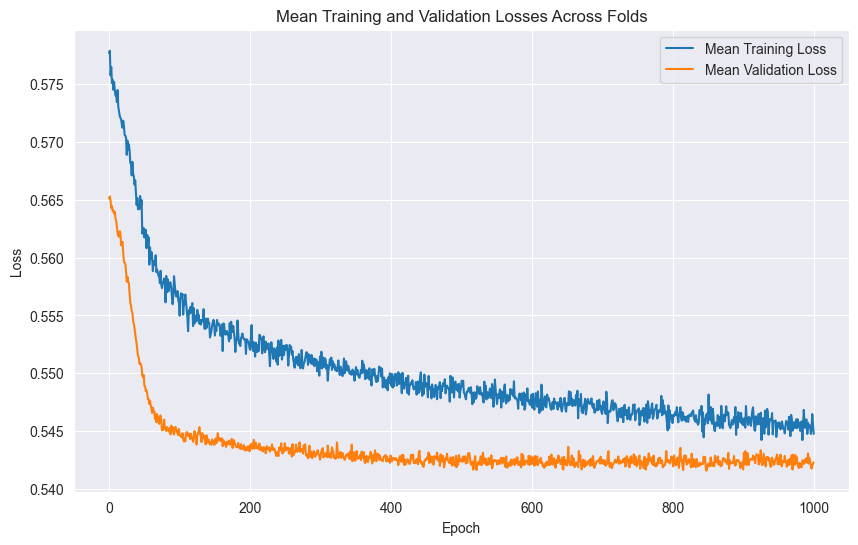

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean training and validation losses across all folds
mean_training_loss = np.mean(training_loss, axis=0)
mean_validation_loss = np.mean(validation_loss, axis=0)

# Plot mean training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(mean_training_loss, label='Mean Training Loss')
plt.plot(mean_validation_loss, label='Mean Validation Loss')

plt.title('Mean Training and Validation Losses Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_auc_score,precision_score ,f1_score


125/125 [==============================] - 0s 892us/step
0.7825995421470034


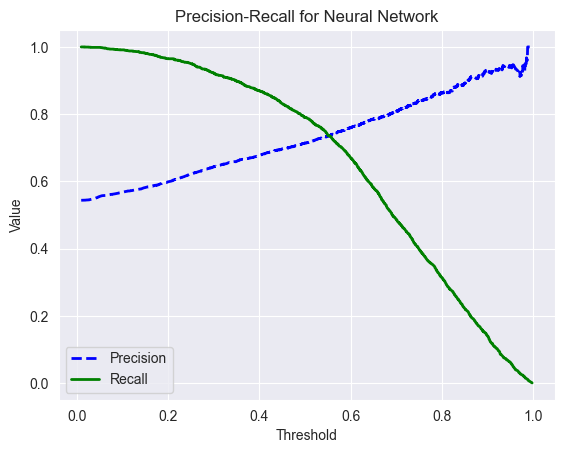

In [33]:

# Assuming model is your trained neural network model and test_X is your test data
y_scores = model.predict(scaled_test_X)  # Predict probabilities for the positive class
roc=roc_auc_score(test_y,y_scores)
print(roc)
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(test_y, y_scores)

# Plot precision-recall curve
plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision-Recall for Neural Network')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Convert continuous scores to binary labels (example thresholding)
threshold = 0.5
y_pred_binary = np.where(y_scores >= threshold, 1, 0)

# Ensure proper data types (convert to integers if necessary)
test_y = np.array(test_y, dtype=int)
y_pred_binary = np.array(y_pred_binary, dtype=int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_y, y_pred_binary).ravel()

# Calculate sensitivity (recall), specificity, precision, and accuracy
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1=f1_score(test_y,y_pred_binary)
# Print the calculated metrics
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1 Score:",f1)
print(confusion_matrix(test_y,y_pred_binary))

Sensitivity (Recall): 0.7907407407407407
Specificity: 0.6230684326710817
Precision: 0.7143454621497282
Accuracy: 0.7142497482376636
F1 Score: 0.7506042627993847
[[1129  683]
 [ 452 1708]]


In [39]:
idx_for_90_precision = (precision >= 0.8).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)
print(recall[idx_for_90_precision])

0.008965545
1.0


In [37]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print("Precision:",precision_score(test_y, y_train_pred_90))
print("f1 score:",f1_score(test_y, y_train_pred_90))


Precision: 0.5438066465256798
f1 score: 0.7045009784735813


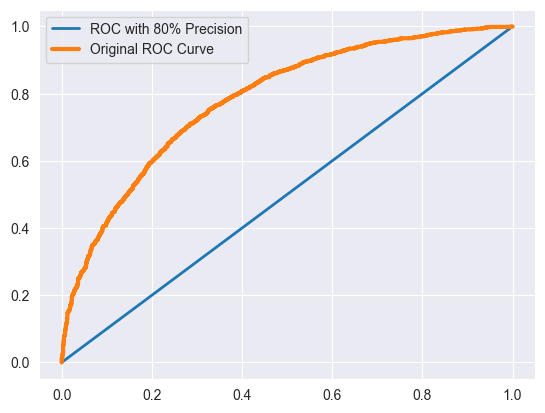

In [40]:
fpr, tpr, thresholds = roc_curve(test_y, y_train_pred_90)
fpr2, tpr2, thresholds2 = roc_curve(test_y, y_scores)

plt.plot(fpr, tpr, linewidth=2, label="ROC with 80% Precision")
plt.plot(fpr2, tpr2, linewidth=3, label="Original ROC Curve")
plt.legend()



In [41]:

xgb.fit(oversampled_x_train,oversampled_y_train)
predictions= xgb.predict(scaled_test_X)
cm=confusion_matrix(test_y,predictions)
print(cm)
roc=roc_auc_score(test_y,predictions)
print('ROC:',roc)
print('F1 score:',f1_score(test_y,predictions))
print('###################\n')
print('classification report:',classification_report (test_y,predictions))
tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
# Calculate sensitivity (recall), specificity, precision, and accuracy
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1=f1_score(test_y,y_pred_binary)
# Print the calculated metrics
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

[[1202  610]
 [ 509 1651]]
ROC: 0.7138536301201863
F1 score: 0.7468898439267134
###################

classification report:               precision    recall  f1-score   support

           0       0.70      0.66      0.68      1812
           1       0.73      0.76      0.75      2160

    accuracy                           0.72      3972
   macro avg       0.72      0.71      0.71      3972
weighted avg       0.72      0.72      0.72      3972

Sensitivity (Recall): 0.7643518518518518
Specificity: 0.6633554083885209
Precision: 0.7302078726227333
Accuracy: 0.7182779456193353


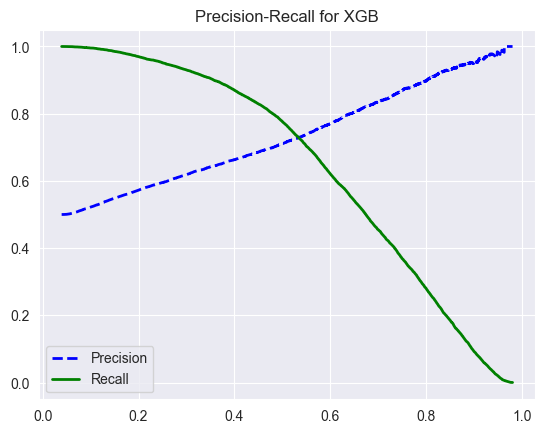

In [42]:
plt.title('Precision-Recall for XGB')
plot_precison_recall(xgb,oversampled_x_train,oversampled_y_train,4,'predict_proba')

In [43]:
from sklearn.dummy import  DummyClassifier
dummy_clf=DummyClassifier()
dummy_clf.fit(scaled_train_X,train_y)
print(any(dummy_clf.predict(scaled_test_X))) # prints False: no 5s detected
print(cross_val_score(dummy_clf,scaled_train_X,train_y,cv=3,scoring='roc_auc'))

True
[0.5 0.5 0.5]


In [106]:
aVF1 = pd.read_csv(r"C:\Users\Lenovo\PycharmProjects\pythonProject\PTB_XL\ECG_Feature_Extraction\avf_wavelet_transformed.csv", index_col=False)
df=pd.read_csv(r"C:\Users\Lenovo\PycharmProjects\pythonProject\PTB_XL\ECG_Feature_Extraction\k20_extracted_features.csv",index_col=False)


In [107]:
aVF1.shape

(20000, 5000)

In [109]:
aVF=aVF1.copy().iloc[:,:1000]
aVF.shape

(20000, 1000)

In [110]:
combined_df = pd.concat([df, aVF], axis=1)


In [111]:
combined_df.shape

(20000, 1017)

In [112]:
#Lets check out the dataset first
print('data base 5 first rows \n')
display(combined_df.head())
print('\n')
print('data base information \n')
display(combined_df.info())
print('\n')
print('data base nan values')
display(combined_df.isna().sum())
print('\n database unique values for each column\n')
categorical_columns = combined_df.select_dtypes(include=['object']).columns.tolist()
intcolumns=combined_df.select_dtypes(include=['float64','int64']).columns.tolist()
for i in categorical_columns:
    print(f'{i}')
    display(combined_df[i].nunique())
    display(combined_df[i].unique())

data base 5 first rows 



,HR,RR,R_wave_duration,P_wave_duration,T_wave_duration,PR_interval,ST_interval,R_peak,P_peak,Q_peak,...,990,991,992,993,994,995,996,997,998,999
0,64.0,1.00,0.03,0.02,0.03,0.187,0.061,0.074155,0.001282,-0.050321,...,0.011185,0.022861,0.025760,0.015913,0.001865,-0.010599,-0.018824,-0.016827,-0.006259,0.000498
1,47.0,1.02,0.10,0.03,0.04,0.186,0.020,0.145161,0.001416,-0.056772,...,0.000051,0.001311,0.002048,0.001497,0.000529,-0.000148,-0.000793,-0.001669,-0.002081,-0.001172
2,64.0,1.01,0.03,0.03,0.03,0.181,0.065,0.098840,0.003009,-0.012145,...,0.000730,-0.011099,-0.021218,-0.022343,-0.014856,-0.007135,-0.001824,0.010478,0.030777,0.043300
3,75.0,1.00,0.04,0.03,0.03,0.154,0.063,0.078532,0.009152,-0.088432,...,0.002579,0.008557,0.010882,0.009395,0.006258,0.003391,0.001136,-0.001058,-0.003053,-0.003715
4,66.0,1.00,0.04,0.03,0.03,0.190,0.086,0.021135,0.002147,-0.005118,...,0.000837,0.000413,-0.000145,0.000085,0.000403,-0.000244,-0.001109,-0.000959,-0.000041,0.000471




data base information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1017 entries, HR to 999
dtypes: float64(1014), int64(2), object(1)
memory usage: 155.2+ MB


None



data base nan values


HR                  1
RR                  1
R_wave_duration     6
P_wave_duration     6
T_wave_duration    50
                   ..
995                 0
996                 0
997                 0
998                 0
999                 0
Length: 1017, dtype: int64


 database unique values for each column

Axis


3

array(['Left Axis Deviation', 'Right Axis Deviation',
       'Normal or Left Axis Deviation'], dtype=object)

In [113]:
combined_df = pd.get_dummies(combined_df, columns=categorical_columns)
combined_df = combined_df.astype(float)

combined_df['weight'] = combined_df['weight'].fillna(combined_df['weight'].median())
combined_df.dropna(inplace=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19860 entries, 0 to 19999
Columns: 1019 entries, HR to Axis_Right Axis Deviation
dtypes: float64(1019)
memory usage: 154.6 MB


In [129]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Concatenate, Flatten

# Assuming you have loaded your ECG data into the variable aVF
# Reshape aVF to match the shape of the other features

X=combined_df.drop(columns=['diagnostic_superclass','patient_id'])
y=combined_df['diagnostic_superclass']
# Split your data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize your features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote=SMOTE(k_neighbors=50,random_state=42)

oversampled_x_train,oversampled_y_train=smote.fit_resample(X_train_scaled,y_train)


In [134]:
from xgboost import XGBClassifier


xgb = XGBClassifier(
    n_estimators=1000,         # Number of boosting rounds
    learning_rate=0.001,        # Step size shrinkage used in update to prevent overfitting
    max_depth=8,               # Maximum depth of a tree
    gamma=5,                   # Minimum loss reduction required to make a further partition on a leaf node
    colsample_bytree=0.5,
    min_child_weight=1,        # Minimum sum of instance weight (hessian) needed in a child
    reg_alpha=0,               # L1 regularization term on weights
    reg_lambda=1,              # L2 regularization term on weights
    scale_pos_weight=1,        # Control the balance of positive and negative weights
    objective='binary:logistic',  # Specify the learning task and the corresponding learning objective
    eval_metric='auc'         # Evaluation metric for validation data
)
# Perform cross-validation
cross = cross_val_score(xgb, X_train_scaled, y_train, cv=3, scoring='roc_auc')

# Print the mean cross-validation score
print(cross.mean())


0.7903813591387884


In [132]:
from sklearn.metrics import recall_score,precision_score
xgb.fit(oversampled_x_train,oversampled_y_train)
predictions= xgb.predict(X_test_scaled)
cm=confusion_matrix(y_test,predictions)
print(cm)
roc=roc_auc_score(y_test,predictions)
print('ROC:',roc)
print('F1 score:',f1_score(y_test,predictions))
print('Accuracy:',accuracy_score(y_test,predictions))
print('recall:',recall_score(y_test,predictions))
print('precision:',precision_score(y_test,predictions))

print('###################\n')
print('classification report:',classification_report (y_test,predictions))
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# Calculate sensitivity (recall), specificity, precision, and accuracy
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1=f1_score(y_test,y_pred_binary)
# Print the calculated metrics
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Accuracy:", accuracy)

[[1131  567]
 [ 572 1702]]
ROC: 0.7072693002166137
F1 score: 0.7492846136913934
Accuracy: 0.7132426988922457
recall: 0.7484608619173263
precision: 0.750110180696342
###################

classification report:               precision    recall  f1-score   support

         0.0       0.66      0.67      0.67      1698
         1.0       0.75      0.75      0.75      2274

    accuracy                           0.71      3972
   macro avg       0.71      0.71      0.71      3972
weighted avg       0.71      0.71      0.71      3972

Sensitivity (Recall): 0.7484608619173263
Specificity: 0.666077738515901
Precision: 0.750110180696342
Accuracy: 0.7132426988922457


In [91]:
from keras.layers import Conv1D, Conv2D,MaxPooling1D
from keras.callbacks import EarlyStopping


In [120]:
# Reshape your data for convolutional layer (assuming your data is in the form of time series)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define your CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the Model
model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

# Evaluate the Model
loss, auc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test AUC: {auc:.4f}')

Epoch 1/50
398/398 [==============================] - 8s 15ms/step - loss: 0.6902 - auc: 0.4910 - val_loss: 0.6845 - val_auc: 0.5000
Epoch 2/50
398/398 [==============================] - 6s 15ms/step - loss: 0.6883 - auc: 0.4963 - val_loss: 0.6863 - val_auc: 0.5000
Epoch 3/50
398/398 [==============================] - 6s 15ms/step - loss: 0.6885 - auc: 0.5036 - val_loss: 0.6846 - val_auc: 0.5000
Epoch 4/50
175/398 [============>.................] - ETA: 3s - loss: 0.6875 - auc: 0.4905

KeyboardInterrupt: 

In [128]:
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten
from keras.optimizers import Adam, SGD
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_reshaped.shape[1],)),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Step 3: Compile the Model
model.compile(optimizer=SGD(learning_rate=0.005), loss='binary_crossentropy', metrics=['AUC'])

# Step 4: Train the Model
history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_split=0.1)

# Step 5: Evaluate the Model
loss, auc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test AUC: {auc:.4f}')

Epoch 1/500
447/447 [==============================] - 2s 2ms/step - loss: 0.6986 - auc: 0.4979 - val_loss: 0.6910 - val_auc: 0.5701
Epoch 2/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6894 - auc: 0.5168 - val_loss: 0.6901 - val_auc: 0.5381
Epoch 3/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6890 - auc: 0.5161 - val_loss: 0.6888 - val_auc: 0.5981
Epoch 4/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6885 - auc: 0.5150 - val_loss: 0.6885 - val_auc: 0.6457
Epoch 5/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6883 - auc: 0.5196 - val_loss: 0.6885 - val_auc: 0.6231
Epoch 6/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6874 - auc: 0.5308 - val_loss: 0.6861 - val_auc: 0.6605
Epoch 7/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6881 - auc: 0.5195 - val_loss: 0.6860 - val_auc: 0.6800
Epoch 8/500
447/447 [==============================] - 1s 2ms/step - 

KeyboardInterrupt: 

In [125]:
history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_split=0.1)


Epoch 1/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6558 - auc: 0.6776 - val_loss: 0.6466 - val_auc: 0.7360
Epoch 2/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6565 - auc: 0.6745 - val_loss: 0.6465 - val_auc: 0.7361
Epoch 3/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6569 - auc: 0.6733 - val_loss: 0.6467 - val_auc: 0.7354
Epoch 4/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6552 - auc: 0.6769 - val_loss: 0.6472 - val_auc: 0.7344
Epoch 5/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6552 - auc: 0.6781 - val_loss: 0.6465 - val_auc: 0.7362
Epoch 6/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6557 - auc: 0.6751 - val_loss: 0.6463 - val_auc: 0.7366
Epoch 7/500
447/447 [==============================] - 1s 2ms/step - loss: 0.6551 - auc: 0.6777 - val_loss: 0.6459 - val_auc: 0.7371
Epoch 8/500
447/447 [==============================] - 1s 2ms/step - 

In [126]:
history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_split=0.1)


Epoch 1/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5976 - auc: 0.7398 - val_loss: 0.5803 - val_auc: 0.7647
Epoch 2/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5975 - auc: 0.7395 - val_loss: 0.5824 - val_auc: 0.7655
Epoch 3/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5989 - auc: 0.7388 - val_loss: 0.5814 - val_auc: 0.7651
Epoch 4/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5980 - auc: 0.7388 - val_loss: 0.5801 - val_auc: 0.7649
Epoch 5/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5992 - auc: 0.7375 - val_loss: 0.5803 - val_auc: 0.7650
Epoch 6/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5969 - auc: 0.7400 - val_loss: 0.5803 - val_auc: 0.7650
Epoch 7/500
447/447 [==============================] - 1s 2ms/step - loss: 0.5982 - auc: 0.7393 - val_loss: 0.5811 - val_auc: 0.7648
Epoch 8/500
447/447 [==============================] - 1s 2ms/step - 

KeyboardInterrupt: 

In [121]:
from keras.layers import LSTM
# Build a neural network model with LSTM layers and dropout
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the Model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

# Evaluate the Model
loss, auc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test AUC: {auc:.4f}')

Epoch 1/50
398/398 [==============================] - 199s 491ms/step - loss: 0.6922 - auc: 0.4906 - val_loss: 0.6911 - val_auc: 0.5000
Epoch 2/50
 20/398 [>.............................] - ETA: 2:44 - loss: 0.6918 - auc: 0.5250

KeyboardInterrupt: 

In [ ]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2,callbacks=[early_stopping])
